## Семинар 10: "Генерация текстов"

ФИО: Устинов Иван Вадимович

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [2]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

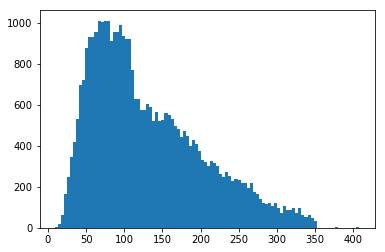

In [3]:
plt.hist(list(map(len, lines)), bins=100);

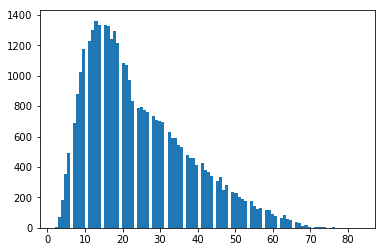

In [4]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [5]:
line = lines[0]

In [6]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [7]:
lines = list(filter(lambda x: len(x.split()) <= 50, lines))

In [8]:
np.random.seed(777)
torch.random.manual_seed(777)

In [9]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [10]:
vocab = Vocabulary(lines)

In [11]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [12]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [13]:
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [14]:
dataset = Quotes(lines, vocab)

In [15]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

### Часть 2: определение модели

In [16]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [17]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [18]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [19]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [20]:
losses = []

In [16]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

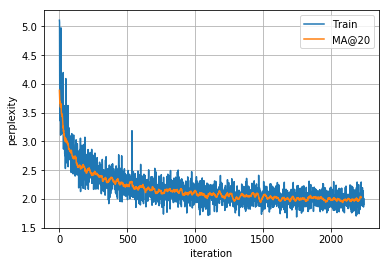

 20%|██        | 108/536 [06:03<27:47,  3.90s/it]

KeyboardInterrupt: 

In [22]:
for epoch in range(200):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [26]:
oracle.generate(vocab), oracle.generate(vocab), oracle.generate(vocab), oracle.generate(vocab)

/home/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


("Detter is a glow. I decondel stances about we's revelen anytrust.<eos>",
 'Soder poor is never hage sostall to more praction.<eos>',
 'I think hapen, abook. When the sut the likes, body. And the progent humbly even infiness the communi',
 'My plown we have some and.<eos>')

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

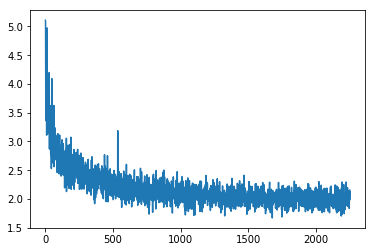

In [25]:
plt.plot(losses)

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [91]:
class OracleLSTM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(OracleLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        _input = Variable(_input).cuda()
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = (Variable(torch.zeros(self.layers, 1, self.hidden_size)).cuda(),
             Variable(torch.zeros(self.layers, 1, self.hidden_size)).cuda())
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True).cuda()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().cpu().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [92]:
oracle_lstm = OracleLSTM(vocab.size, embedding_size=32, hidden_size=64, layers=2)
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []

In [93]:
oracle_lstm.cuda()

OracleLSTM(
  (embedding): Embedding(84, 32)
  (generator): LSTM(32, 64, num_layers=2)
  (classifier): Linear(in_features=64, out_features=84, bias=True)
)

In [94]:
criterion.cuda()

CrossEntropyLoss()

In [95]:
optimizer = torch.optim.Adam(oracle_lstm.parameters(), lr=0.003, weight_decay=1e-5)

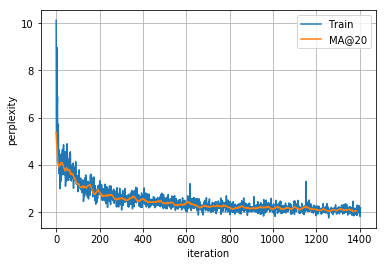






 47%|████▋     | 251/536 [00:20<00:33,  8.58it/s]




 47%|████▋     | 253/536 [00:20<00:29,  9.68it/s]




 48%|████▊     | 255/536 [00:20<00:26, 10.49it/s]




 48%|████▊     | 257/536 [00:20<00:25, 11.11it/s]




 48%|████▊     | 259/536 [00:21<00:24, 11.17it/s]




 49%|████▊     | 261/536 [00:21<00:23, 11.59it/s]




 49%|████▉     | 263/536 [00:21<00:23, 11.56it/s]




 49%|████▉     | 265/536 [00:21<00:23, 11.68it/s]




 50%|████▉     | 267/536 [00:21<00:22, 11.85it/s]




 50%|█████     | 269/536 [00:21<00:22, 11.72it/s]




 51%|█████     | 271/536 [00:22<00:22, 11.94it/s]




 51%|█████     | 273/536 [00:22<00:21, 12.29it/s]




 51%|█████▏    | 275/536 [00:22<00:21, 12.42it/s]




 52%|█████▏    | 277/536 [00:22<00:21, 12.29it/s]




 52%|█████▏    | 279/536 [00:22<00:20, 12.27it/s]

KeyboardInterrupt: 

In [98]:
for epoch in range(200):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle_lstm.zero_grad()
#         go.cuda()
        eos = Variable(eos, requires_grad=False).cuda()
        prediction = oracle_lstm(go, length).transpose(0, 1).transpose(1, 2)
        mask = Variable(mask, requires_grad=False).cuda()
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle_lstm.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [99]:
oracle_lstm.generate(vocab), oracle_lstm.generate(vocab), oracle_lstm.generate(vocab), oracle_lstm.generate(vocab)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


("Gake had you be the thef you're me, and clats coming Digher than jits can famine of I was deadic.<eos>",
 'Anain the race, you do the when I do know.<eos>',
 "No Eved make a bat is move sover for countey's no towanlent of new of the dippred canss deguel a mos",
 'A the indle, Prsply bespy why is peelives stlented, to ality working imform-theything teep and you c')






 52%|█████▏    | 279/536 [00:36<00:20, 12.27it/s]

####  Разобью на test-train, обучу и посмотрю результаты

In [121]:
dataset = Quotes(lines, vocab)

indexes = np.arange(len(dataset))
np.random.shuffle(indexes)

split = len(dataset) * 0.7
train_ind = indexes[:split]
test_ind = indexes[split:]
train_dataset = np.array(dataset)[train_ind]
test_dataset = np.array(dataset)[test_ind]
train_dataloader =  DataLoader(train_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)
test_dataloader =  DataLoader(test_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


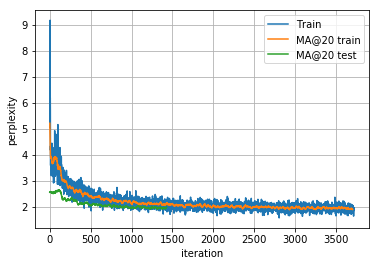












 94%|█████████▍| 352/375 [00:22<00:02,  9.88it/s]










 94%|█████████▍| 354/375 [00:23<00:01, 11.22it/s]










 95%|█████████▌| 357/375 [00:23<00:01, 13.12it/s]










 96%|█████████▌| 360/375 [00:23<00:01, 14.97it/s]










 97%|█████████▋| 363/375 [00:23<00:00, 16.45it/s]










 97%|█████████▋| 365/375 [00:23<00:00, 17.35it/s]










 98%|█████████▊| 368/375 [00:23<00:00, 17.63it/s]










 99%|█████████▊| 370/375 [00:23<00:00, 16.78it/s]










 99%|█████████▉| 372/375 [00:23<00:00, 16.58it/s]










100%|█████████▉| 374/375 [00:24<00:00, 16.32it/s]










100%|██████████| 375/375 [00:24<00:00, 15.54it/s]










  0%|          | 0/375 [00:00<?, ?it/s]










  1%|          | 4/375 [00:00<00:10, 35.10it/s]










  2%|▏         | 9/375 [00:00<00:09, 38.47it/s]










  4%|▎         | 14/375 [00:00<00:09, 39.93it/s]










  6%|▌         | 21/375 [00:00<00:07, 44.70it/s]










  7%|▋         | 28/375 [00:00<00:06, 49.83it

In [131]:
oracle_lstm = OracleLSTM(vocab.size, embedding_size=32, hidden_size=64, layers=2)
criterion = nn.CrossEntropyLoss(reduction='none')

losses_train = []
losses_test = []
losses_train_epoch = []
losses_test_epoch = []

oracle_lstm.cuda()
criterion.cuda()
optimizer = torch.optim.Adam(oracle_lstm.parameters(), lr=0.003, weight_decay=1e-5)

for epoch in range(10):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
        oracle_lstm.zero_grad()
        eos = Variable(eos, requires_grad=False).cuda()
        prediction = oracle_lstm(go, length).transpose(0, 1).transpose(1, 2)
        mask = Variable(mask, requires_grad=False).cuda()
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle_lstm.parameters()]
        optimizer.step()
        losses_train.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses_train, label='Train')
            plt.plot(moving_average(losses_train), label='MA@20 train')
            plt.plot(moving_average(losses_test), label='MA@20 test')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()
            
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(test_dataloader, total=len(train_dataloader))):
        eos = Variable(eos, requires_grad=False).cuda()
        prediction = oracle_lstm(go, length).transpose(0, 1).transpose(1, 2)
        mask = Variable(mask, requires_grad=False).cuda()
        loss = (criterion(prediction, eos)*mask.float()).mean()
        losses_test.append(np.exp(loss.item()))
        
    losses_train_epoch.append(np.array(losses_test).min())
    losses_test_epoch.append(np.array(losses_train).min())

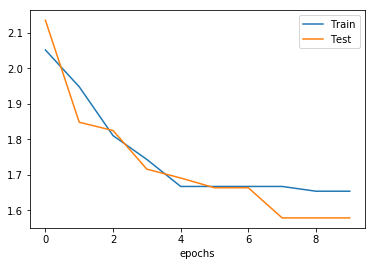

In [132]:
plt.plot(losses_train_epoch, label='Train')
plt.plot(losses_test_epoch, label='Test')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [133]:
oracle_lstm.generate(vocab), oracle_lstm.generate(vocab), oracle_lstm.generate(vocab), oracle_lstm.generate(vocab)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


('Cippoars no lay be numbers that miny; that the Some far movies.<eos>',
 "I want I'm dreater, not are more.<eos>",
 'We me hand that we gam bedy sposkinmellas which idea about now I know he con saps of the stority in ',
 'I priend is holish idees me, really failing happen to have, nullowed,.<eos>')

#### Увеличим количесвто скрытых переменных и скрытых слоев

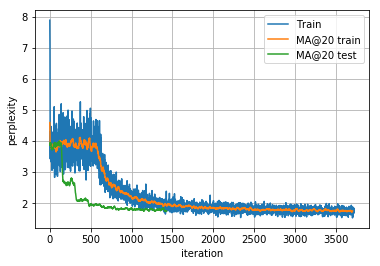












 94%|█████████▎| 351/375 [00:28<00:02, 11.71it/s]










 94%|█████████▍| 353/375 [00:28<00:01, 12.75it/s]










 95%|█████████▍| 355/375 [00:28<00:01, 14.01it/s]










 95%|█████████▌| 357/375 [00:28<00:01, 14.81it/s]










 96%|█████████▌| 359/375 [00:28<00:01, 15.70it/s]










 96%|█████████▋| 361/375 [00:28<00:00, 16.34it/s]










 97%|█████████▋| 363/375 [00:28<00:00, 17.06it/s]










 97%|█████████▋| 365/375 [00:29<00:00, 16.76it/s]










 98%|█████████▊| 367/375 [00:29<00:00, 17.22it/s]










 98%|█████████▊| 369/375 [00:29<00:00, 17.48it/s]










 99%|█████████▉| 371/375 [00:29<00:00, 17.24it/s]










 99%|█████████▉| 373/375 [00:29<00:00, 17.56it/s]










100%|██████████| 375/375 [00:29<00:00, 17.59it/s]










  0%|          | 0/375 [00:00<?, ?it/s]










  1%|▏         | 5/375 [00:00<00:08, 42.58it/s]










  3%|▎         | 10/375 [00:00<00:08, 42.48it/s]










  4%|▍         | 15/375 [00:00<00:08, 42.8

In [134]:
oracle_lstm = OracleLSTM(vocab.size, embedding_size=32, hidden_size=128, layers=4)
criterion = nn.CrossEntropyLoss(reduction='none')

losses_train2 = []
losses_test2 = []
losses_train_epoch2 = []
losses_test_epoch2 = []

oracle_lstm.cuda()
criterion.cuda()
optimizer = torch.optim.Adam(oracle_lstm.parameters(), lr=0.003, weight_decay=1e-5)

for epoch in range(10):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
        oracle_lstm.zero_grad()
        eos = Variable(eos, requires_grad=False).cuda()
        prediction = oracle_lstm(go, length).transpose(0, 1).transpose(1, 2)
        mask = Variable(mask, requires_grad=False).cuda()
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle_lstm.parameters()]
        optimizer.step()
        losses_train2.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses_train2, label='Train')
            plt.plot(moving_average(losses_train2), label='MA@20 train')
            plt.plot(moving_average(losses_test2), label='MA@20 test')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()
            
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(test_dataloader, total=len(train_dataloader))):
        eos = Variable(eos, requires_grad=False).cuda()
        prediction = oracle_lstm(go, length).transpose(0, 1).transpose(1, 2)
        mask = Variable(mask, requires_grad=False).cuda()
        loss = (criterion(prediction, eos)*mask.float()).mean()
        losses_test2.append(np.exp(loss.item()))
        
    losses_train_epoch2.append(np.array(losses_test2).min())
    losses_test_epoch2.append(np.array(losses_train2).min())

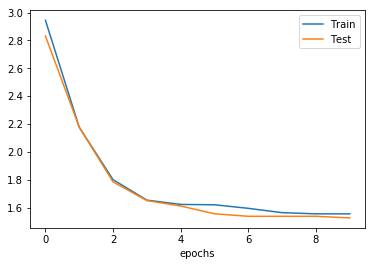

In [135]:
plt.plot(losses_train_epoch2, label='Train')
plt.plot(losses_test_epoch2, label='Test')
plt.xlabel('epochs')
plt.legend()
plt.show()

По сравнению с предыдущим случаем ошибка упала с примерно 1.7 до примерно 1.6

In [136]:
oracle_lstm.generate(vocab), oracle_lstm.generate(vocab), oracle_lstm.generate(vocab), oracle_lstm.generate(vocab)

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


('The time to tell health friends will no longer country in me.<eos>',
 'To me that mother people, so its proves by the prines that school why believe to the use of himself ',
 'Rules, twurn in understand the wave the human family, coura.<eos>',
 'As a situation have a release of fairing.<eos>')

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: